In [206]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error,root_mean_squared_error
hol_df = pd.read_csv("holidays_events.csv")
stores_df = pd.read_csv("stores.csv")
oil_df = pd.read_csv("oil.csv")
trans_df = pd.read_csv("transactions.csv")
test_df = pd.read_csv("test.csv")
train_df = pd.read_csv("train.csv")
print(hol_df['type'].unique())
print(hol_df['locale'].unique())

['Holiday' 'Transfer' 'Additional' 'Bridge' 'Work Day' 'Event']
['Local' 'Regional' 'National']


NOTE: Pay special attention to the transferred column. A holiday that is transferred officially falls on that calendar day, but was moved to another date by the government. A transferred day is more like a normal day than a holiday. To find the day that it was actually celebrated, look for the corresponding row where type is Transfer. For example, the holiday Independencia de Guayaquil was transferred from 2012-10-09 to 2012-10-12, which means it was celebrated on 2012-10-12. Days that are type Bridge are extra days that are added to a holiday (e.g., to extend the break across a long weekend). These are frequently made up by the type Work Day which is a day not normally scheduled for work (e.g., Saturday) that is meant to payback the Bridge.
Additional holidays are days added a regular calendar holiday, for example, as typically happens around Christmas (making Christmas Eve a holiday). 

those two are categorical columns about the date

In [207]:
print(hol_df.info())
print("--------")
print(stores_df.info())
print("--------")
print(trans_df.info())
print("--------")
print(oil_df.info())
print("--------")
print(train_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         350 non-null    object
 1   type         350 non-null    object
 2   locale       350 non-null    object
 3   locale_name  350 non-null    object
 4   description  350 non-null    object
 5   transferred  350 non-null    bool  
dtypes: bool(1), object(5)
memory usage: 14.1+ KB
None
--------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   store_nbr  54 non-null     int64 
 1   city       54 non-null     object
 2   state      54 non-null     object
 3   type       54 non-null     object
 4   cluster    54 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 2.2+ KB
None
--------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83488 entries, 

In [208]:
len(oil_df)

1218

the oil_df comes with 1218-1175 values missing in the dcoilwtico column

In [209]:
print("to train the forecasting model we can only use data after: "+str(test_df['date'].min())+ " and before "+str(test_df['date'].max()))
print("hol_df['date'].max() "+str(hol_df['date'].max()))
print("oil['date'].max() "+str(oil_df['date'].max()))
print("trans_df['date'].max() "+str(trans_df['date'].max()))

to train the forecasting model we can only use data after: 2017-08-16 and before 2017-08-31
hol_df['date'].max() 2017-12-26
oil['date'].max() 2017-08-31
trans_df['date'].max() 2017-08-15


we can use the oil price and holidays to train the model, lets see if oil price its related to overall sales

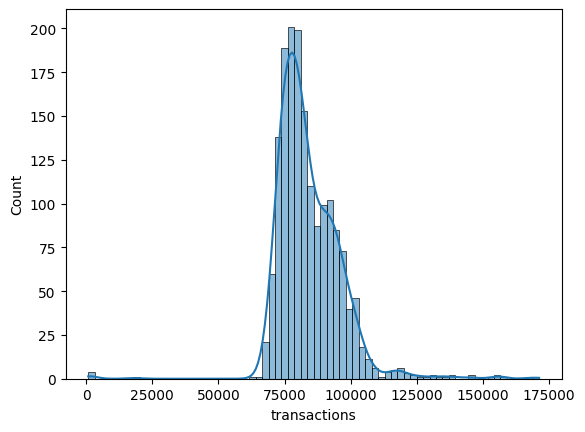

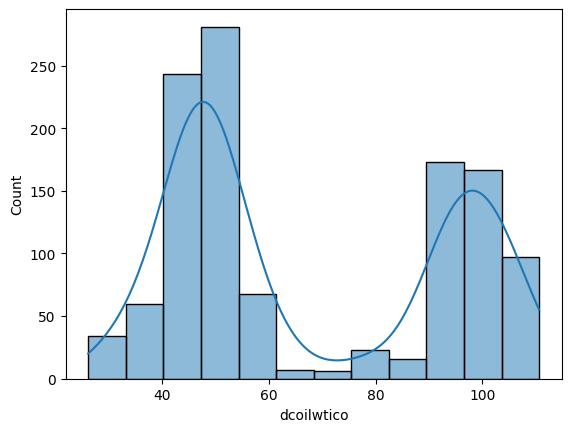

In [210]:
daily_transactions = trans_df.groupby("date")['transactions'].sum()

sns.histplot(data=daily_transactions,kde=True)
plt.show()
sns.histplot(data=oil_df,x='dcoilwtico' ,kde=True)
plt.show()

the oil price df is bimodal, not normal, so we will use spearman instead of pearson

In [211]:
def normalize_series(series):
    min_val = series.min()
    max_val = series.max()
    normalized = (series - min_val) / (max_val - min_val)
    return normalized

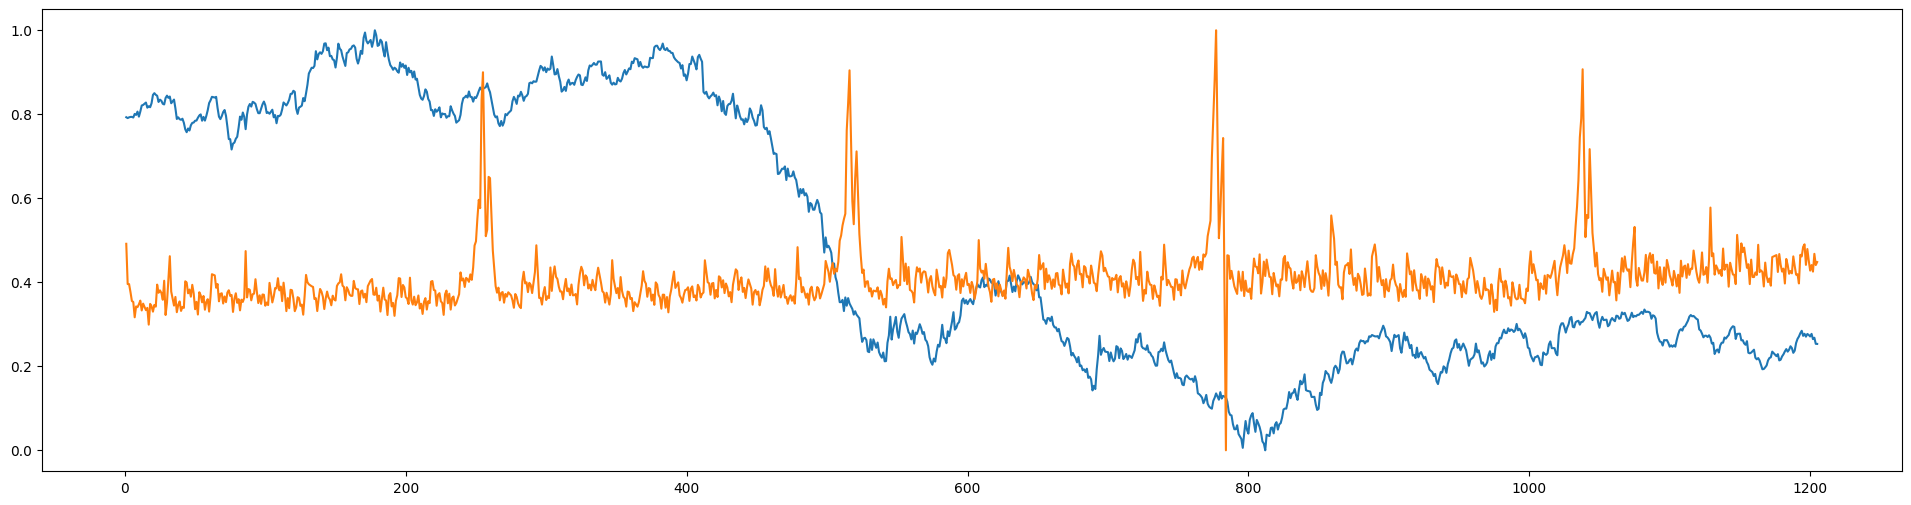

In [212]:
oil_and_trans_corr_df = oil_df.merge(daily_transactions, 
            left_on='date', 
            right_index=True,
            how='inner')

oil_and_trans_corr_df = oil_and_trans_corr_df[~(oil_and_trans_corr_df['dcoilwtico'].isnull())] #remove dates where there is no info about the oil
figsize_long_plots =(24, 6)
plt.figure(figsize=figsize_long_plots)
plt.plot(normalize_series(oil_and_trans_corr_df['dcoilwtico']))
plt.plot(normalize_series(oil_and_trans_corr_df['transactions']))
plt.show()

There are outlyers ins the oil info but they dont interfere as much in a spearman correlation

In [213]:
float(oil_and_trans_corr_df['dcoilwtico'].corr(oil_and_trans_corr_df['transactions'], method='spearman'))

-0.4187712354354692

its a light linear relation but lets take it in count to train the model

lets see if the number of items on promotion is related to the daily sales of a product

but first lets check for null data

In [214]:
train_df.isna().sum()

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

In [ ]:
promoted_train_df= train_df[train_df['onpromotion']>0] #lets use this dataframe to visualize better the data
sns.histplot(data=promoted_train_df, x='onpromotion',kde=True)
plt.xlim((0,promoted_train_df['onpromotion'].std()+promoted_train_df['onpromotion'].median()))
plt.show()
sns.histplot(data=train_df, x='sales',kde=True)
plt.xlim((0,train_df['sales'].std()+train_df['sales'].median()))
plt.show()

we can see that the both distributions are not normal, so we cant use pearson, lets use spearman

In [216]:
float(train_df['sales'].corr(train_df['onpromotion'], method='spearman'))

0.5380218163559225

so as we can see, we should use 'onpromotion' and 'oil' to try to predict the sales, since both are linearly related to the sales of a product, now we have to test the holidays

In [217]:
hol_df=hol_df[hol_df["transferred"]==False] #removing not important info
hol_df.groupby(by='date').size().sort_values(ascending=False).head()

date
2014-06-25    4
2013-06-25    3
2017-06-25    3
2016-06-25    3
2012-06-25    3
dtype: int64

there are dates with more than one holiday, this means that in order to relate the sales of a day to a holyday variable, we will have to relate it to a list of categorical variables 

In [218]:
hol_to_store_col = {
    'Regional':'state',
    'Local':'city',
    'National':'country'
}


In [219]:
hol_transfered = hol_df[hol_df['type']=='Transfer']
for _, hol in hol_df[hol_df['type']!='Transfer'].iterrows():
    mask = hol_df['description'].str.contains(hol['description'], regex=False)
    hol_df.loc[mask, 'description'] = hol['description']

for _, hol in hol_df[hol_df['type']!='Transfer'].iterrows():
    mask = hol_df['description'].str.contains(hol['description'], regex=False)
    print(hol_df[mask])

           date     type locale locale_name         description  transferred
0    2012-03-02  Holiday  Local       Manta  Fundacion de Manta        False
46   2013-03-02  Holiday  Local       Manta  Fundacion de Manta        False
93   2014-03-02  Holiday  Local       Manta  Fundacion de Manta        False
164  2015-03-02  Holiday  Local       Manta  Fundacion de Manta        False
214  2016-03-02  Holiday  Local       Manta  Fundacion de Manta        False
301  2017-03-02  Holiday  Local       Manta  Fundacion de Manta        False
           date     type    locale locale_name                    description  \
1    2012-04-01  Holiday  Regional    Cotopaxi  Provincializacion de Cotopaxi   
47   2013-04-01  Holiday  Regional    Cotopaxi  Provincializacion de Cotopaxi   
96   2014-04-01  Holiday  Regional    Cotopaxi  Provincializacion de Cotopaxi   
165  2015-04-01  Holiday  Regional    Cotopaxi  Provincializacion de Cotopaxi   
216  2016-04-01  Holiday  Regional    Cotopaxi  Provinci

In [220]:
for i in hol_df['type'].drop_duplicates():
    trans_df[i]=0

#iterate for all holydays
for _, hol in hol_df.iterrows():
    stores_affected = []
    store_locale_column = hol_to_store_col[hol['locale']]

    if(store_locale_column=='country'):
        stores_affected=stores_df['store_nbr'].unique()
    else:
        stores_affected=stores_df[stores_df[store_locale_column]==hol['locale_name']]['store_nbr']
    
    store_mask = trans_df['store_nbr'].isin(stores_affected)
    date_mask = trans_df['date'] == hol['date']

    trans_df.loc[date_mask & store_mask, hol['type']] = 1

In [221]:
stores_df.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


Found this about types and clusters in the stores dataset <br>
Good point. Not sure what cluster is, but I looked into type and performed EDA on types. You can go to the grocery chain's web site:

https://www.corporacionfavorita.com/en/brands/commercial-area/

And from Wikipedia, as of 2016:

From Wikipedia:

Supermaxi (35 locations as of 2016)
Megamaxi (12 locations as of 2016)
Akí (38 locations as of 2016)
Gran Akí (17 locations as of 2016)
Súper Akí (5 locations as of 2016)

I don't know for sure, but when I did some work on this a few weeks ago, my best guess ended up as:

D 18 Aki
C 15 SuperMaxi
A 9 Megamaxi
B 8 Gran Aki
E 4 Super Aki

In [222]:
from scipy.stats import mannwhitneyu, spearmanr

trans_during_holidays = trans_df[(trans_df[hol_df['type'].unique()]>0).any(axis=1)]
trans_without_holidays = trans_df[~((trans_df[hol_df['type'].unique()]>0).any(axis=1))]
rel_sells_holyday, p_value = mannwhitneyu(trans_during_holidays['transactions'], trans_without_holidays['transactions'])
print(f"rel_sells_holyday = {rel_sells_holyday}, p_value {p_value}")

rel_sells_holyday = 292406229.5, p_value 5.5295583768591555e-39


since p_value < 0.05 we can say that the fact of having a holiday affects the sales of a day, now, lets see if the type of holiday affects as well

In [223]:
len(hol_df['description'].unique())

51

if we wanted to add all possible holidays to our LSTM model for it to use this, we would have to use a one hot encoder with 103 values. <br> 
We have some options:
- Clusterize the holidays by the similarity of impact in sales
- Use the holiday type instead of the holiday name
- Use the holiday day

In [224]:
dict_hol_type_relation = {}

for t in hol_df['type'].unique():
    rel, pv = spearmanr(trans_df['transactions'], trans_df[t]) 
    print(f"{t}: rel {rel} pv {pv}")
    if(pv<0.05):
        print(f'This is valid')
    dict_hol_type_relation[t]=rel

Holiday: rel -0.007995687235202447 pv 0.020871584139339504
This is valid
Transfer: rel -0.0019687572138251917 pv 0.56945763094409
Additional: rel 0.09533183850756244 pv 8.93471538221235e-168
This is valid
Bridge: rel 0.009447693425864868 pv 0.006336045982997818
This is valid
Work Day: rel 0.015033974828911171 pv 1.398218558013961e-05
This is valid
Event: rel 0.0016481013026850258 pv 0.6339316395810989


p < 0.05 → Statistically significant <br>
The correlation is unlikely to be due to random chance.<br>
Commonly accepted threshold for validity in most scientific studies.<br>
<br>
p ≥ 0.05 → Not statistically significant<br>
The observed correlation could be due to random variation.<br>
The result is not considered strong evidence of a true relationship.<br>

There is no way that the relation between this typ of holidays are not linear, so this means that a day being a holiday has no relation with the sales during that day.

Lets take a look at the train_df

In [ ]:
train_df.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0
1,1,2013-01-01,1,BABY CARE,0.000,0
2,2,2013-01-01,1,BEAUTY,0.000,0
3,3,2013-01-01,1,BEVERAGES,0.000,0
4,4,2013-01-01,1,BOOKS,0.000,0
...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8


/tmp/ipykernel_7247/2292264438.py:21: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


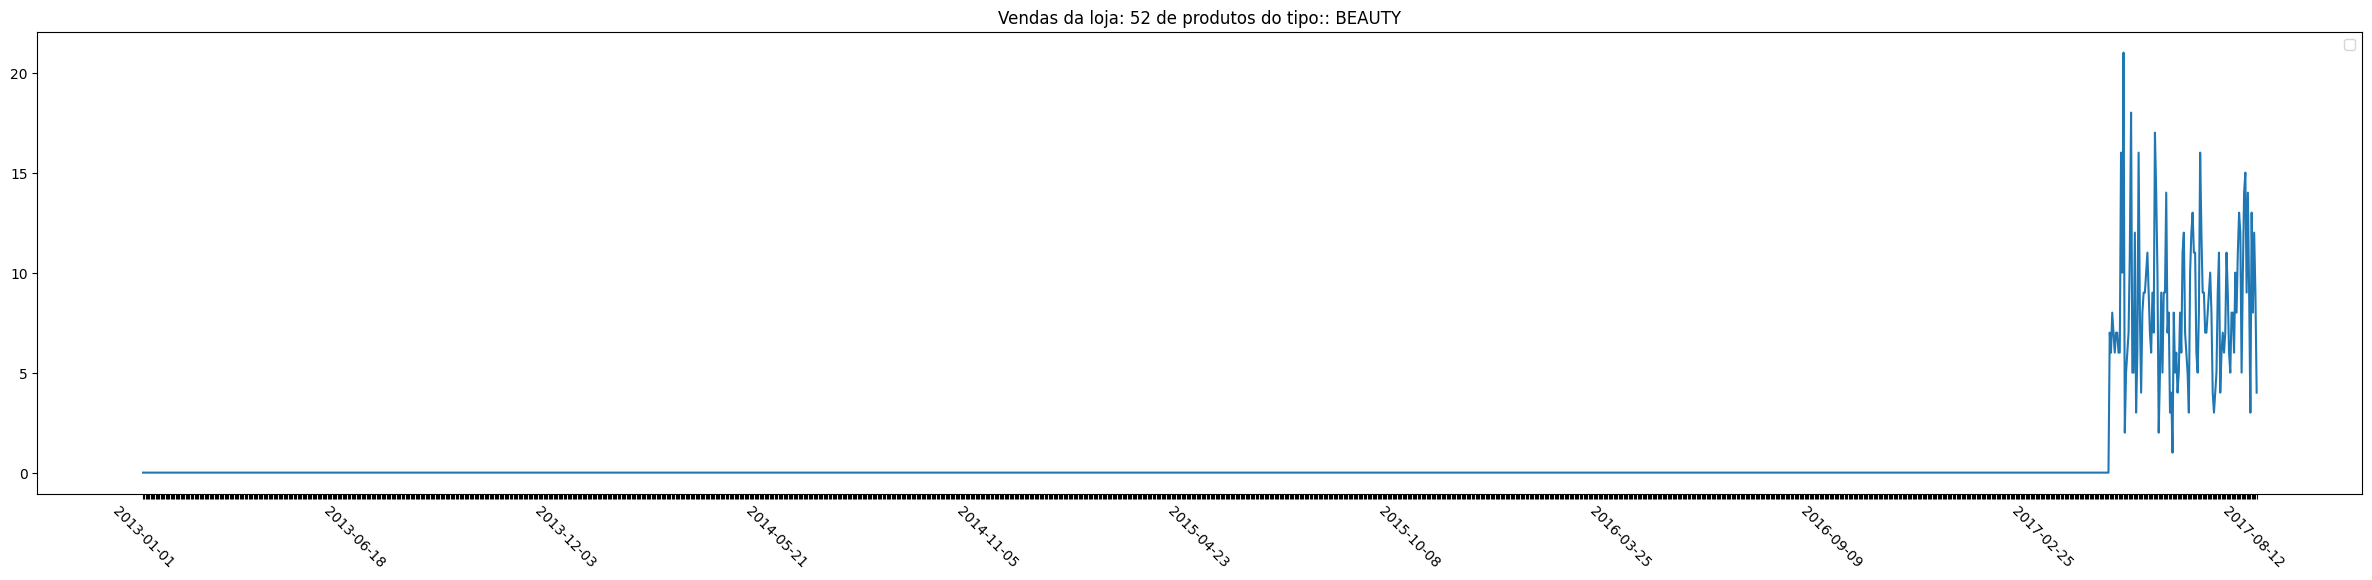

/tmp/ipykernel_7247/2292264438.py:21: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


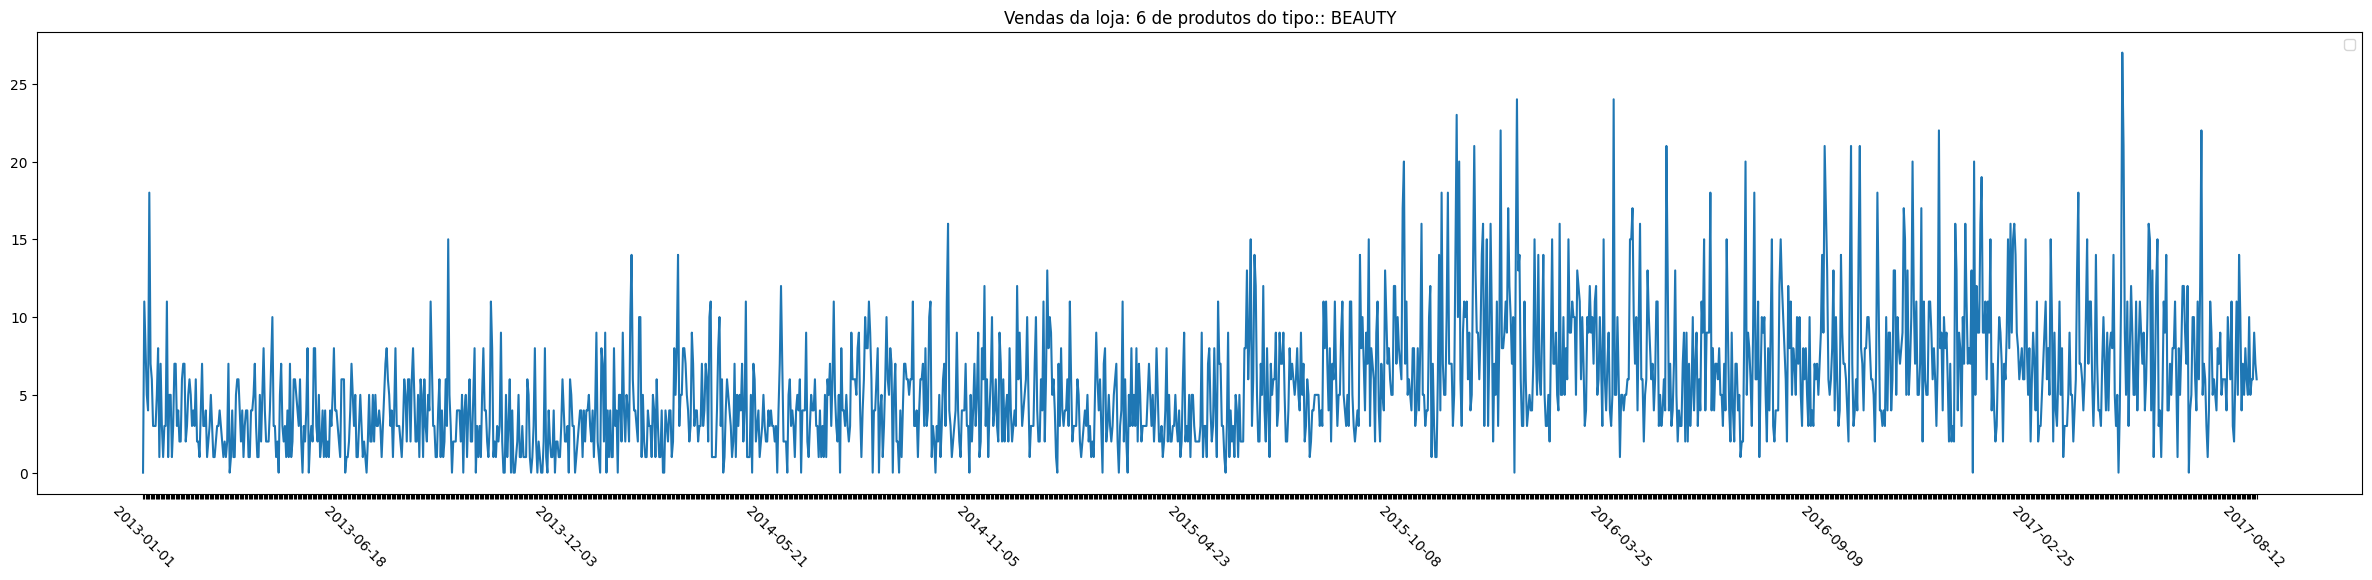

/tmp/ipykernel_7247/2292264438.py:21: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


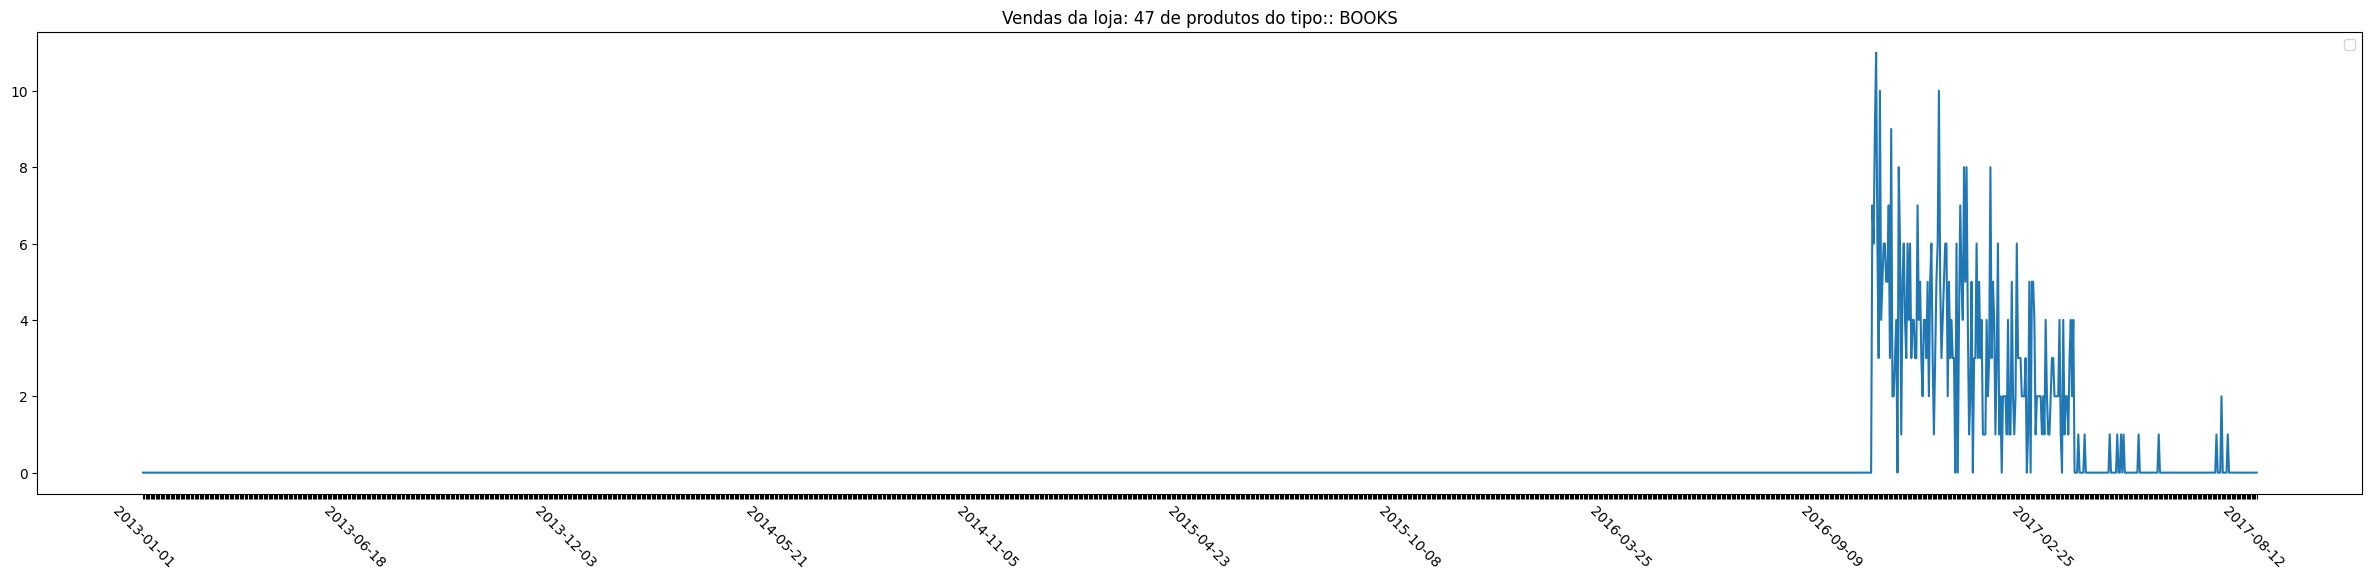

In [226]:
def print_dfs_sales(df_separated,indexes):
    for i in indexes:

        df:pd.DataFrame = df_separated[i]

        if df.empty:
            print(f"DataFrame at index {i} is empty - skipping plot")
            continue 

        y = list(df['sales'])
        x = list(df['date'])

        step = max(1,(len(x)-1)//10)
        ticks = list(range(len(x)))
        labels = [x[t] if t%step ==0 else '' for t in list(range(len(y)))]

        plt.figure(figsize=(30,6))
        plt.title(f"Vendas da loja: {df['store_nbr'].iloc[0]} de produtos do tipo:: {df['family'].iloc[0]}")
        plt.plot(range(len(y)),y)
        plt.xticks(ticks, labels,rotation=-45)
        plt.legend()
        plt.show()

train_df_separated:list[pd.DataFrame] = [df for title, df in  train_df.groupby(by=['store_nbr', 'family'])]

random_indexes = np.random.choice(len(train_df_separated), size = 3, replace=True)
print_dfs_sales(train_df_separated, random_indexes)

we have to remove the rows when there are more than 20 consecutive zeros, this probably means that the store did not have the product in storage

/tmp/ipykernel_7247/2292264438.py:21: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


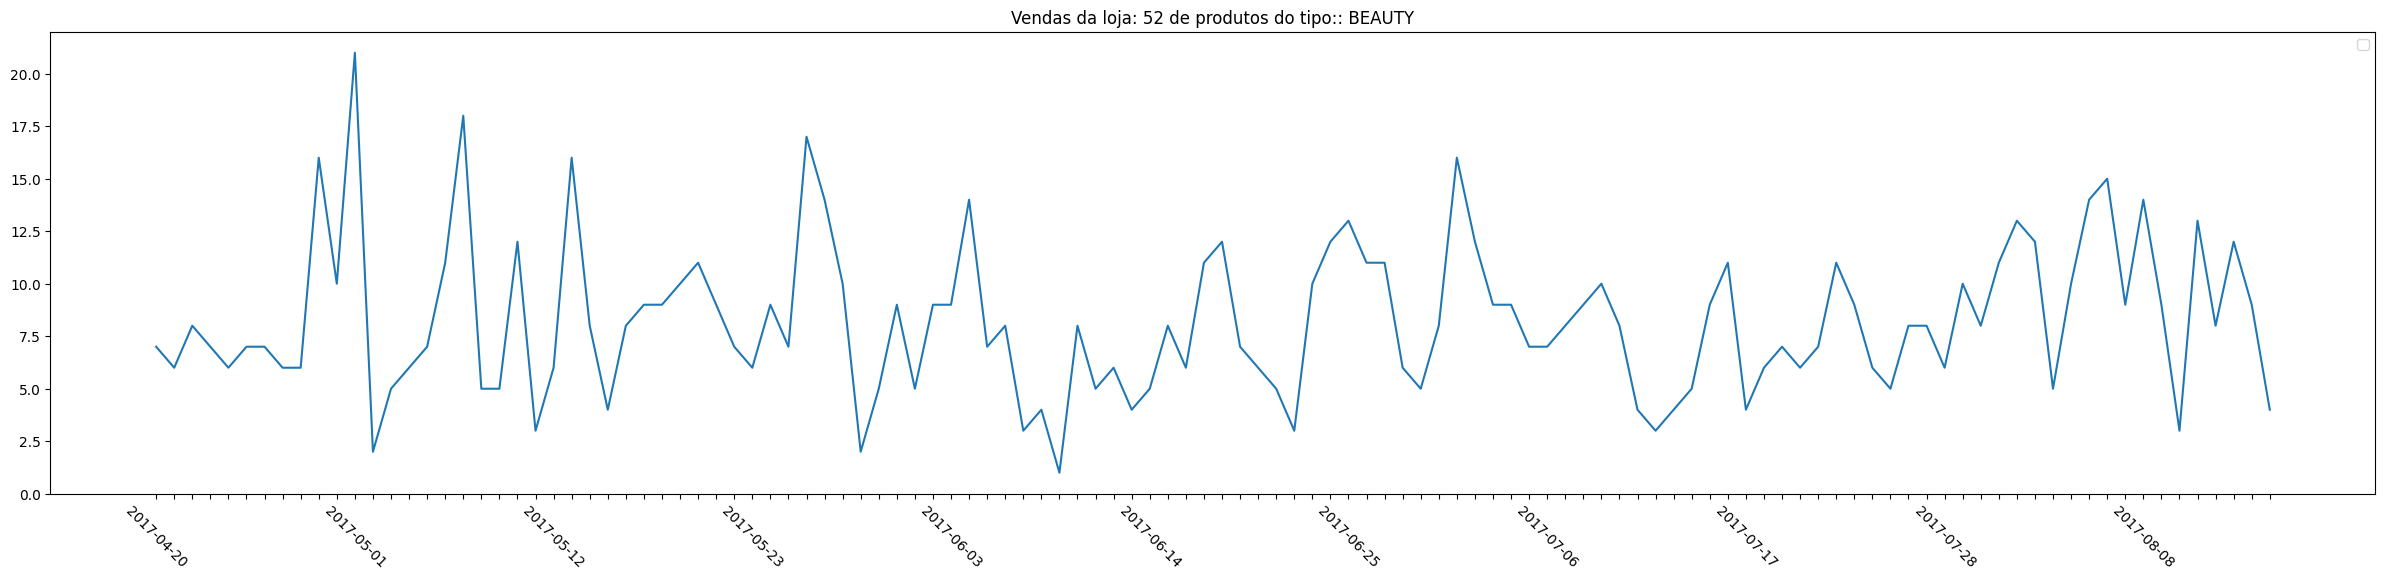

/tmp/ipykernel_7247/2292264438.py:21: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


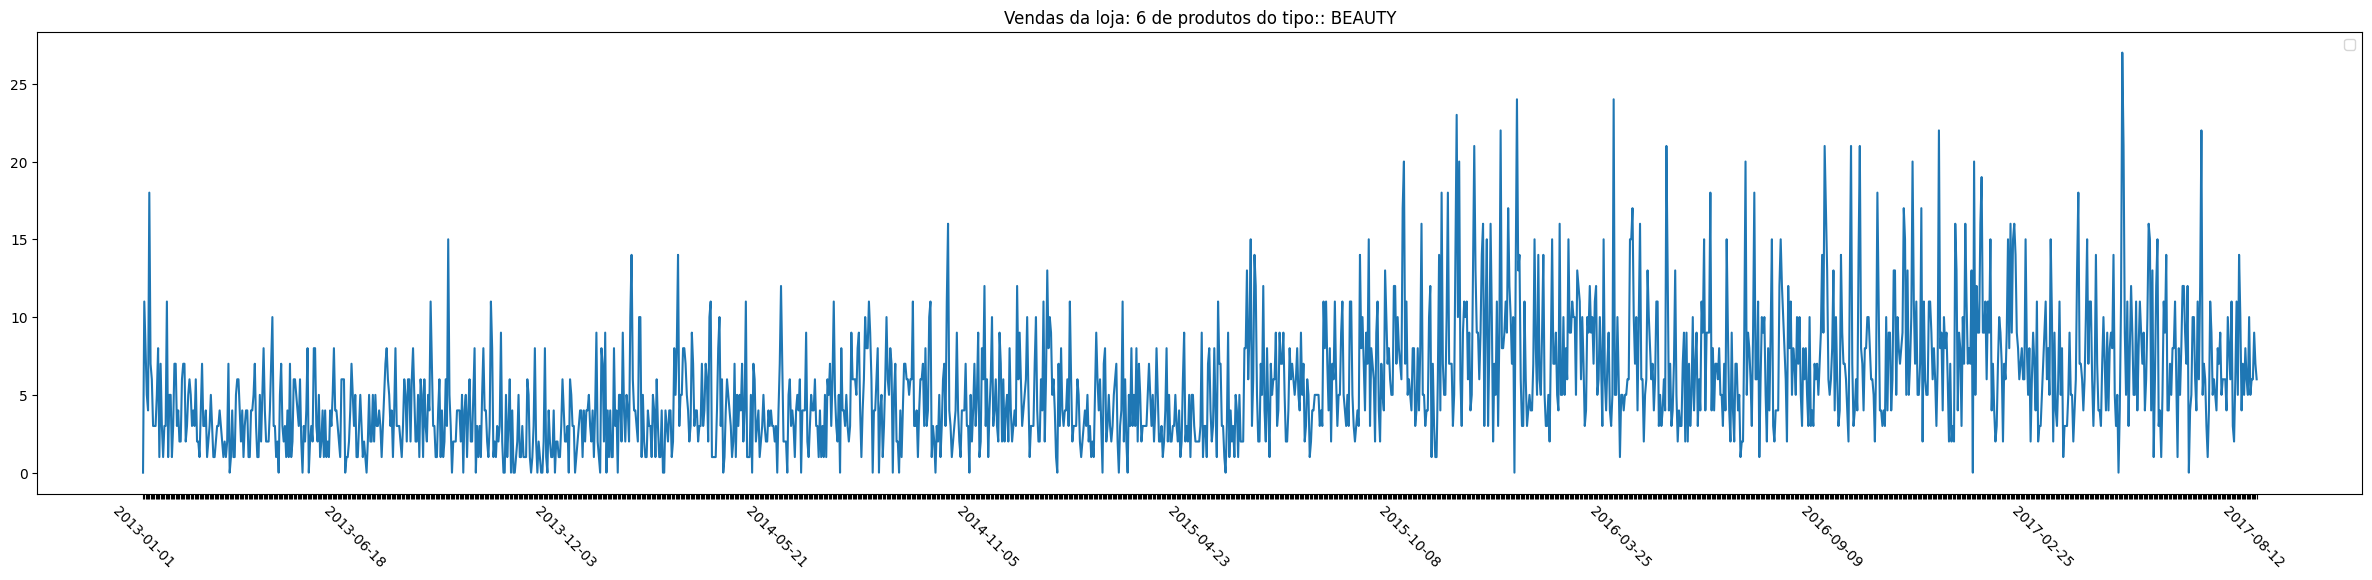

/tmp/ipykernel_7247/2292264438.py:21: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


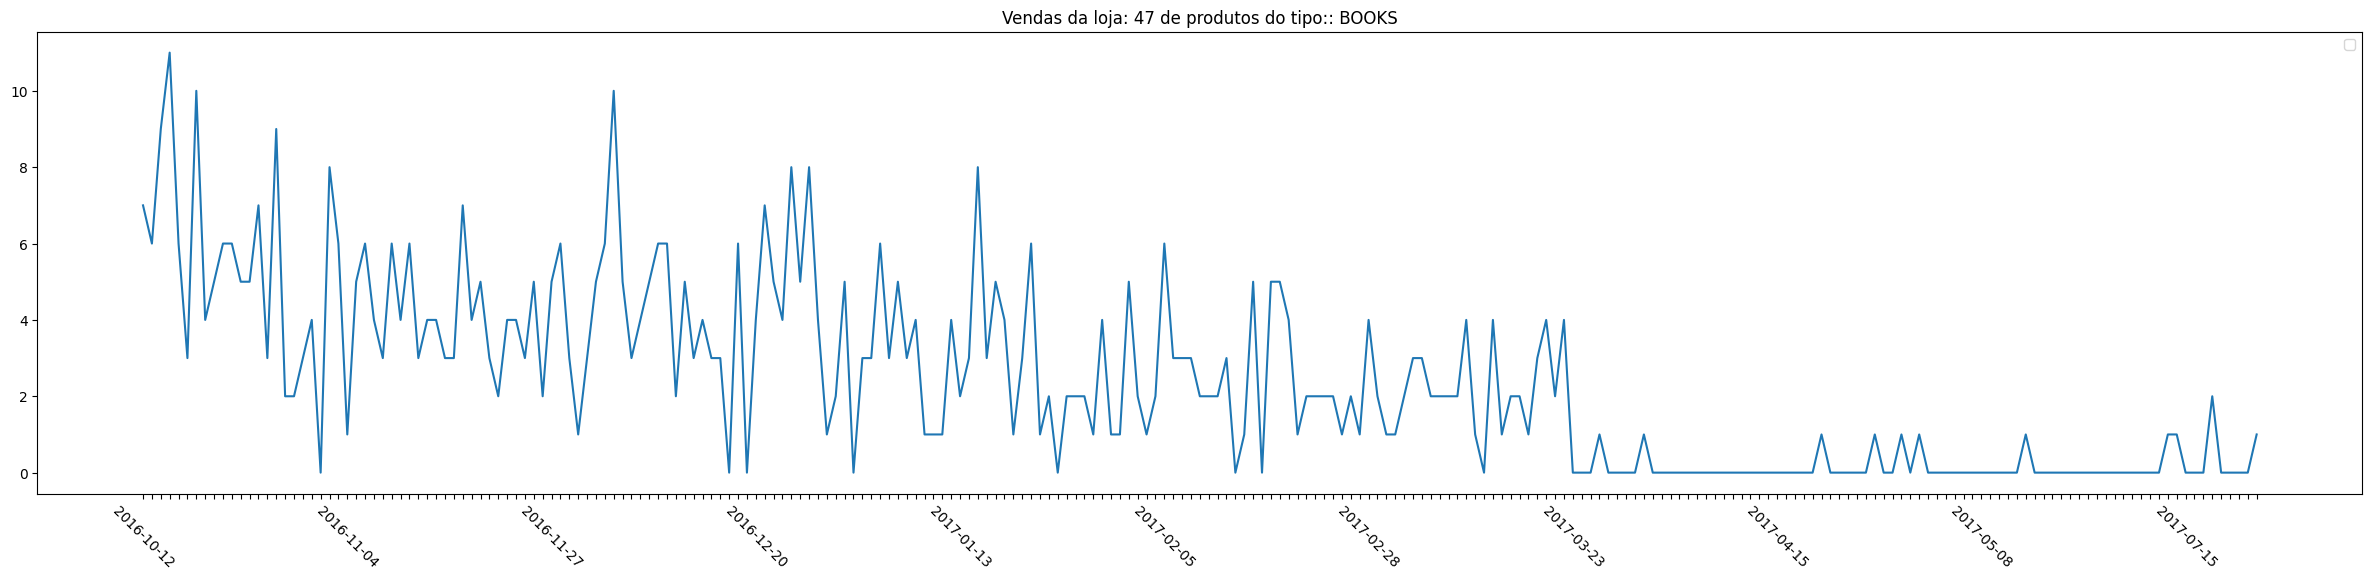

In [227]:

for i,df in enumerate(train_df_separated):
    mask = df['sales'] == 0
    

    groups = (~mask).cumsum()
    zero_counts = mask.groupby(groups).transform('sum')
    train_df_separated[i] = df[~((df['sales'] == 0) & (zero_counts > 20))]


print_dfs_sales(train_df_separated,random_indexes)

In [228]:
train_df = pd.concat(train_df_separated).sort_values(by="date")

Now i will use the description of the holiday as a input to the model for it to predict the sales of a day

In [229]:
trans_df.drop(hol_df['type'].unique(),axis=1, inplace=True)

In [230]:
hol_rank = {
    'Local':1, 
    'Regional':2, 
    'National':3
}

In [231]:
test_df['hol_description']='none'
train_df['hol_description']='none'
test_df['hol_locale']=0
train_df['hol_locale']=0

#iterate for all holydays
for _, hol in hol_df.iterrows():
    stores_affected = []
    store_locale_column = hol_to_store_col[hol['locale']]

    if(store_locale_column=='country'):
        stores_affected=stores_df['store_nbr'].unique()
    else:
        stores_affected=stores_df[stores_df[store_locale_column]==hol['locale_name']]['store_nbr']
    
    store_mask = test_df['store_nbr'].isin(stores_affected)
    date_mask = test_df['date'] == hol['date']
    locale_mask = test_df['hol_locale'] < hol_rank[hol['locale']]

    test_df.loc[store_mask & date_mask & locale_mask, 'hol_description'] = hol['description']

    store_mask = train_df['store_nbr'].isin(stores_affected)
    date_mask = train_df['date'] == hol['date']
    locale_mask = train_df['hol_locale'] < hol_rank[hol['locale']]

    train_df.loc[store_mask & date_mask & locale_mask, 'hol_description'] = hol['description']


preprocessing oil_df

In [232]:
oil_df = pd.read_csv('oil.csv')

In [233]:
#for _, oil_row in oil_df[oil_df['date'].isin(pd.concat([train_df['date'], test_df['date']], ignore_index=True))].iterrows():
oil_df = oil_df[oil_df['date'].isin(pd.concat([train_df['date'], test_df['date']], ignore_index=True))]

null_percentage_training_ds = (oil_df[oil_df['dcoilwtico'].isnull()].size/oil_df.size)*100
null_percentage_training_ds

3.292181069958848

Since its a low null percentage, we will interpolate

In [234]:
oil_df.set_index('date', inplace=True)
oil_df.index = pd.to_datetime(oil_df.index)
oil_df['dcoilwtico'] = oil_df['dcoilwtico'].interpolate(method='time')
oil_df = oil_df[~oil_df['dcoilwtico'].isnull()]

Now we merge it to create the test and valid dataset

In [235]:
train_df['date'] = pd.to_datetime(train_df['date'])
train_df=train_df.merge(left_on='date',
                right=oil_df,
                right_index=True,
                )
test_df['date'] = pd.to_datetime(test_df['date'])
test_df=test_df.merge(left_on='date',
                right=oil_df,
                right_index=True,
                )

print(test_df[test_df['dcoilwtico'].isnull()].size)
print(train_df[train_df['dcoilwtico'].isnull()].size)

0
0


now the two datasets are ready lets go

In [236]:
print(f"quantidade de clusters de lojas {len(stores_df['cluster'].unique())}")
print(f"quantidade de tipos de lojas {len(stores_df['type'].unique())}")
print(f"quantidade de lojas {len(stores_df['store_nbr'].unique())}")

quantidade de clusters de lojas 17
quantidade de tipos de lojas 5
quantidade de lojas 54


Looking maximize precision, we got 3 options:
- Use the store nbr as a nominal variable for the lstm model, to detect useful patterns in each store. But this could need more data, becaouse this reduces the data for each store.<br><br>
- Assumming that that patterns repeat between each 5 clusters and use that instead of the store number, but this will mean assuming information that we dont know.<br><br>
- Doing the same for the store type, the information online is that this indicates the name of the store brand (like wallmart vs costco) but since all thoose supermarket sell the same items, there is no reason to assume that the sales patterns repeat in each store type.

For the first model i will use the store type. And since this is a 1-1 relationship i dont have to use one hot encoding

In [237]:
train_df["store_type"] = 0
test_df["store_type"] = 0
for t in stores_df['type'].unique():
    store_numbers = stores_df[stores_df['type']==t]['store_nbr']
    train_df.loc[train_df['store_nbr'].isin(store_numbers), "store_type"] = t
    test_df.loc[test_df['store_nbr'].isin(store_numbers), "store_type"] = t

print("product families: "+str(len(train_df['family'].unique())))
print("product families that are not in test df but are in train df: "+str(len(train_df[~(train_df['family'].isin(test_df['family']))]['family'])))

product families: 33
product families that are not in test df but are in train df: 0


/tmp/ipykernel_7247/1381414471.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'D' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  train_df.loc[train_df['store_nbr'].isin(store_numbers), "store_type"] = t
/tmp/ipykernel_7247/1381414471.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'D' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  test_df.loc[test_df['store_nbr'].isin(store_numbers), "store_type"] = t


add collumns that can be used as date, becouse date column is a string, and set categorical columns as categorical (preprocessing for lgbm)

In [238]:
import lightgbm as lgb
categorical_variables = ['family','store_nbr','store_type','hol_description']
def preprocess(df:pd.DataFrame):
    for c in categorical_variables:
        df[c] = df[c].astype('category')
        

    preprocessed_df = df
    preprocessed_df['weekDay']= preprocessed_df['date'].dt.weekday
    preprocessed_df['monthDay']= preprocessed_df['date'].dt.day
    preprocessed_df['month']= preprocessed_df['date'].dt.month

    return preprocessed_df

preprocessed_train_df=preprocess(train_df)
preprocessed_train_df = preprocessed_train_df.drop(['date','sales','id'], axis=1)
saved_test_id = test_df['id']
test_df=preprocess(test_df).drop(['date','id'], axis=1)

In [239]:
def train_test_split(x:pd.DataFrame,y:pd.DataFrame, test_size = 0.2):
    assert len(x)==len(y)
    cut_idx=int(len(x)*(1-test_size))

    train_x = x.iloc[0:cut_idx,:]
    train_y = y.iloc[0:cut_idx]
    test_x = x.iloc[cut_idx:,:]
    test_y = y.iloc[cut_idx:]

    return train_x, train_y, test_x, test_y, cut_idx

Creating and training models

In [240]:
y_series =  pd.Series(data=train_df['sales'].to_numpy(), index=train_df['date'])
x_train, y_train, x_test , y_test, cut_idx = train_test_split(preprocessed_train_df, y_series, test_size=0.4)
y_test:pd.Series=y_test

train_ds = lgb.Dataset(
    x_train,
    label=y_train,
    categorical_feature=categorical_variables,
)
test_ds = lgb.Dataset(
    x_test,
    label=y_test,
    categorical_feature=categorical_variables
)

In [241]:
params_sales_pred = {
    'objective': 'poisson', 
    'metric': 'rmse',
    'learning_rate': 0.1,
    'num_leaves': 32,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'verbosity': -1
}
model = lgb.train(
    params_sales_pred,
    train_ds,
    num_boost_round=1000,
    valid_sets=[test_ds],
    callbacks=[lgb.early_stopping(stopping_rounds=50)]
)

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[141]	valid_0's rmse: 537.169


In [242]:
print(x_test['family'].unique().to_numpy(),flush=True)
products_to_forecast = input("Escreva uma das anteriores familias de produtos para prever sua demanda: ")
while products_to_forecast not in x_test['family'].unique().to_numpy():
    products_to_forecast = input("Escreva UMA DAS ANTERIORES familias de produtos para prever sua demanda: ")

['PRODUCE' 'GROCERY II' 'PERSONAL CARE' 'DELI' 'CELEBRATION' 'BEVERAGES'
 'BEAUTY' 'HOME AND KITCHEN II' 'PLAYERS AND ELECTRONICS'
 'HOME APPLIANCES' 'DAIRY' 'LADIESWEAR' 'HOME CARE' 'MAGAZINES'
 'PET SUPPLIES' 'HARDWARE' 'BABY CARE' 'POULTRY' 'BREAD/BAKERY'
 'GROCERY I' 'EGGS' 'LIQUOR,WINE,BEER' 'FROZEN FOODS' 'LAWN AND GARDEN'
 'SEAFOOD' 'HOME AND KITCHEN I' 'CLEANING' 'PREPARED FOODS'
 'SCHOOL AND OFFICE SUPPLIES' 'LINGERIE' 'AUTOMOTIVE' 'MEATS' 'BOOKS']


In [243]:
from numpy.typing import ArrayLike
from typing import Optional

def plot_mask_creator(df:pd.Series):
    
    return ((df['family']==products_to_forecast) & (df['store_nbr']==1))

def plot_results(y_true, y_pred, title, mask: Optional[ArrayLike] = None):
    plt.figure(figsize=figsize_long_plots)
    plt.grid(True, alpha=0.3)
    if(mask is not None):
        plt.plot(y_true[mask].sort_index(), label=f'Vendas diárias')
        plt.plot(y_pred[mask].sort_index(), label=f'Vendas diárias previstas pelo modelo', linestyle='--')
    else:
        plt.plot(y_true.sort_index(), label='Valores Reais')
        plt.plot(y_pred.sort_index(), label='Predições', linestyle='--')
    plt.title(title)
    plt.legend()
    plt.show()

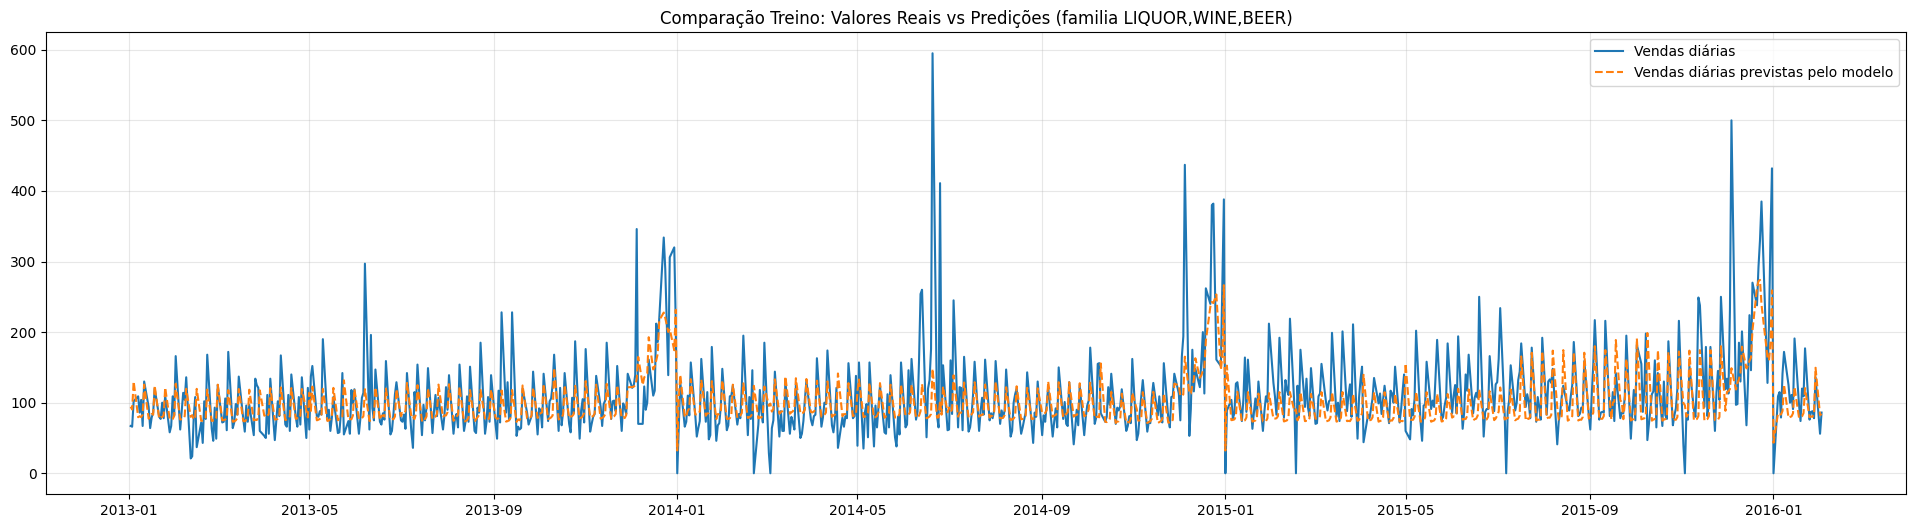

RMSE: 537.17
MAE: 130.49


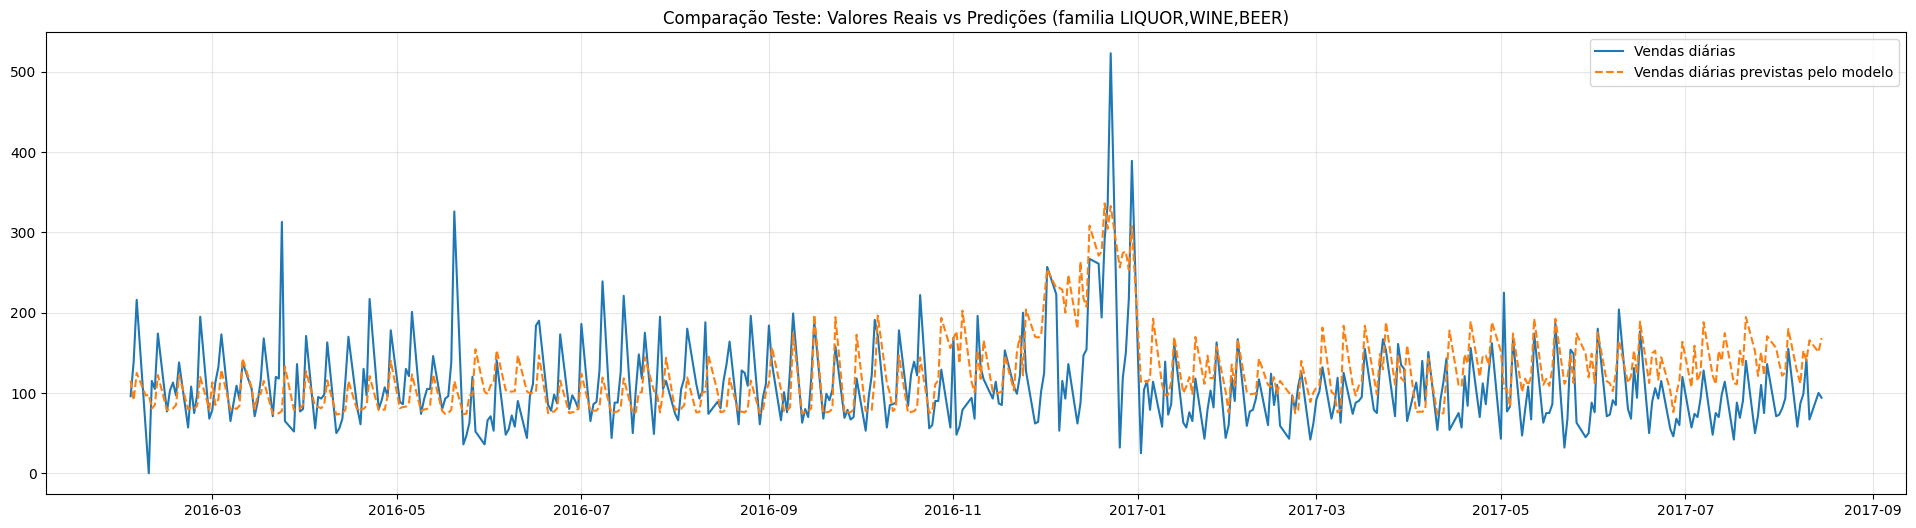

In [244]:
y_train_pred = pd.Series(model.predict(x_train))

mask = plot_mask_creator(x_train).reset_index(drop=True).to_numpy()

y_train_pred.index=y_train.index
plot_results(y_train, y_train_pred, f"Comparação Treino: Valores Reais vs Predições (familia {products_to_forecast})", mask=mask)

#now predicting the test_df (never seen before by the model)
y_test_pred = model.predict(x_test)
y_test_pred = pd.Series(y_test_pred)

print(f"RMSE: {root_mean_squared_error(y_test, y_test_pred):.2f}")
print(f"MAE: {mean_absolute_error(y_test, y_test_pred):.2f}")

mask = plot_mask_creator(x_test).reset_index(drop=True).to_numpy()
y_test_pred.index=y_test.index
plot_results(y_test, y_test_pred, f"Comparação Teste: Valores Reais vs Predições (familia {products_to_forecast})",mask=mask)

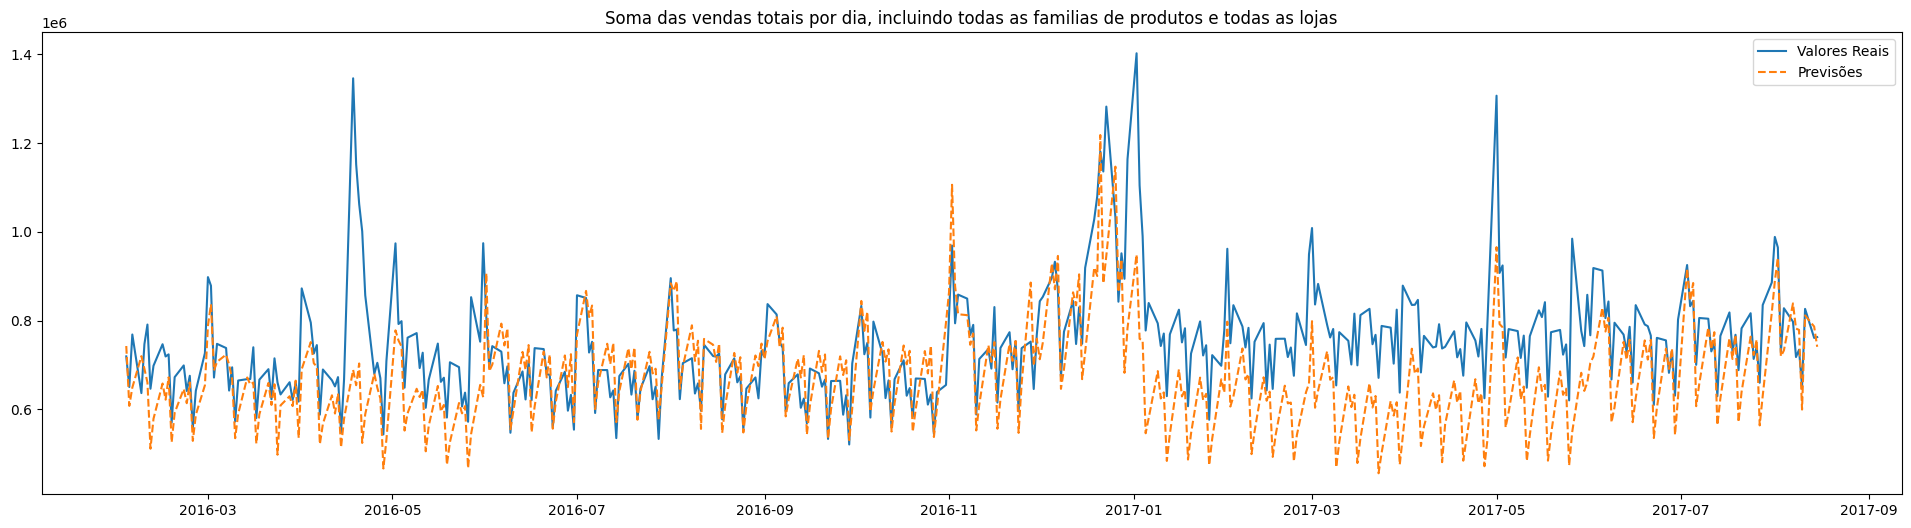

In [245]:
plt.figure(figsize=figsize_long_plots)
plt.plot(y_test.groupby(y_test.index).sum(),label='Valores Reais')
plt.plot(y_test_pred.groupby(y_test_pred.index).sum(),label='Previsões',linestyle='--')
plt.title(f"Soma das vendas totais por dia, incluindo todas as familias de produtos e todas as lojas")
plt.legend()
plt.show()

In [246]:
train_y_delta = (y_train - y_train_pred)
test_y_delta = (y_test - y_test_pred)

train_y_delta.index = x_train.index
test_y_delta.index = x_test.index

lookback_lgbm_train_df = x_train
lookback_lgbm_test_df = x_test
lookback_lgbm_train_df['date'] =y_train.index
lookback_lgbm_test_df['date'] =y_test.index

lookback_lgbm_train_df['pred_diff'] = train_y_delta
lookback_lgbm_test_df['pred_diff'] = test_y_delta


/tmp/ipykernel_7247/753491830.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lookback_lgbm_train_df['date'] =y_train.index
/tmp/ipykernel_7247/753491830.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lookback_lgbm_test_df['date'] =y_test.index
/tmp/ipykernel_7247/753491830.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-

In [247]:
top_lookback_lgbm_train_df, _, lookback_lgbm_test_df, _, _ = train_test_split(x_test,x_test['pred_diff'],test_size=0.1)
lookback_lgbm_train_df = pd.concat([lookback_lgbm_train_df, top_lookback_lgbm_train_df],ignore_index=True)

In [248]:

lookback_lgbm_train_dfs = [df for (_,df) in lookback_lgbm_train_df.groupby(by=['store_nbr', 'family'])]
lookback_lgbm_test_dfs = [df for (_,df) in lookback_lgbm_test_df.groupby(by=['store_nbr', 'family'])]

def add_lookback_features(dfs:list[pd.DataFrame], window_len):
    for df in dfs:
        for i in range(window_len):
            df[f'pred_diff-{i+1}'] = df['pred_diff'].shift(i+1)
        df[f'rolling_pred_diff_mean'] = df['pred_diff'].rolling(window_len, min_periods=1).mean().shift(1)

window_len=5
add_lookback_features(lookback_lgbm_train_dfs,5)
add_lookback_features(lookback_lgbm_test_dfs,5)

lookback_lgbm_train_df = pd.concat(lookback_lgbm_train_dfs, ignore_index=True)
lookback_lgbm_test_df = pd.concat(lookback_lgbm_test_dfs, ignore_index=True)
lookback_lgbm_train_df.set_index('date',inplace=True)
lookback_lgbm_test_df.set_index('date',inplace=True)

lookback_train_ds = lgb.Dataset(
    lookback_lgbm_train_df.drop(["pred_diff"],axis=1),
    label=lookback_lgbm_train_df["pred_diff"],
    categorical_feature=categorical_variables,
)
lookback_test_ds = lgb.Dataset(
    lookback_lgbm_test_df.drop(["pred_diff"],axis=1),
    label=lookback_lgbm_test_df["pred_diff"],
    categorical_feature=categorical_variables,
)

/tmp/ipykernel_7247/1153554546.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  lookback_lgbm_train_dfs = [df for (_,df) in lookback_lgbm_train_df.groupby(by=['store_nbr', 'family'])]
/tmp/ipykernel_7247/1153554546.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  lookback_lgbm_test_dfs = [df for (_,df) in lookback_lgbm_test_df.groupby(by=['store_nbr', 'family'])]


In [249]:
from copy import deepcopy
params_error_pred = deepcopy(params_sales_pred)
params_error_pred['objective'] = 'regression'
lookback_model = lgb.train(
    params=params_error_pred,
    train_set=lookback_train_ds,
    num_boost_round=1000,
    valid_sets=[lookback_test_ds],
    callbacks=[lgb.early_stopping(stopping_rounds=50)]
)

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[91]	valid_0's rmse: 212.837


note that the spike predictions are sometimes delayed, this is a sign that they are not predicting when the spikes ocurr, because the past errors

In [250]:
columns_to_drop = ['pred_diff','rolling_pred_diff_mean']
for c in [f"pred_diff-{i+1}" for i in range(window_len)]:
    columns_to_drop.append(c) 
columns_to_drop

['pred_diff',
 'rolling_pred_diff_mean',
 'pred_diff-1',
 'pred_diff-2',
 'pred_diff-3',
 'pred_diff-4',
 'pred_diff-5']

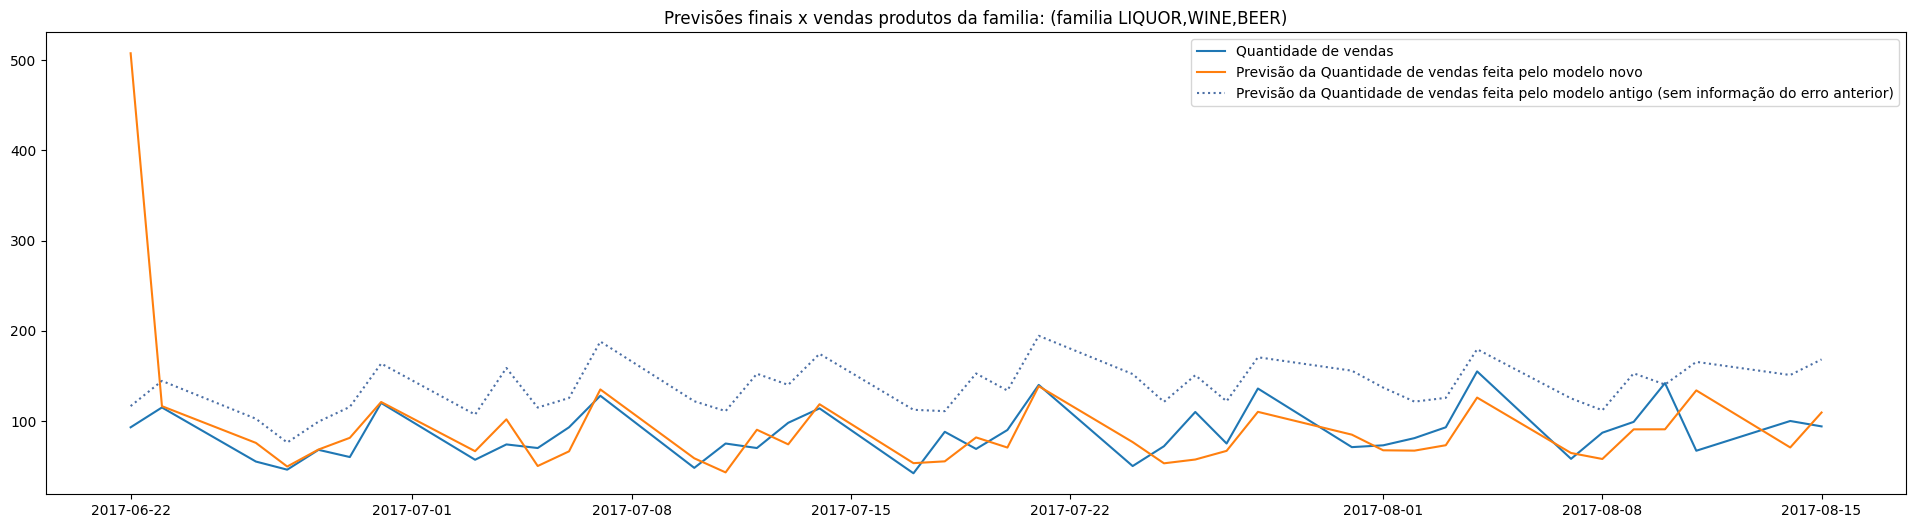

In [251]:
pred = pd.Series(lookback_model.predict(lookback_lgbm_test_df.drop(['pred_diff'],axis=1)))
pred.index= lookback_lgbm_test_df.index
sales_pred = pd.Series(model.predict(lookback_lgbm_test_df.drop(columns_to_drop ,axis=1)))
sales_pred.index = lookback_lgbm_test_df.index

mask = plot_mask_creator(lookback_lgbm_test_df).to_numpy()
final_guess =(sales_pred+pred)[mask]

mask_t = plot_mask_creator(x_test)
truth = y_test[mask_t.to_numpy()]
truth = truth[truth.index >= final_guess.index.min()]

plt.figure(figsize=figsize_long_plots)

plt.plot(truth, label="Quantidade de vendas")
plt.plot(final_guess, label="Previsão da Quantidade de vendas feita pelo modelo novo")
plt.plot(sales_pred[mask],color=(0, 0.2, 0.5, 0.7),linestyle=':',label = "Previsão da Quantidade de vendas feita pelo modelo antigo (sem informação do erro anterior)")[0]
plt.title(f"Previsões finais x vendas produtos da familia: (familia {products_to_forecast})")
plt.legend()
plt.show()

In [252]:
import math
def absError_aux(x,y):
    return math.sqrt((x-y)**2)
abs_error_np = np.vectorize(absError_aux)
abs_model_error=abs_error_np(truth,final_guess)
print(truth.median())
print(round(pd.Series(abs_model_error).median(), 1))

81.0
19.5


Now lets just remember that the new model, knows some of the previous error, so when there is a outlyer peak, and our model follows it, if the model missed by a day, that does not mean our model was able to predict the outlyer, that means that our model saw the previous errors and saw the outlyer, and got biased by it.

now lets train the first model with all dataset in order to submit the results

In [257]:
test_df

,store_nbr,family,onpromotion,hol_description,hol_locale,dcoilwtico,store_type,weekDay,monthDay,month,sales,id
0,1,AUTOMOTIVE,0,none,0,46.80,D,2,16,8,6.175308,3000888
1,1,BABY CARE,0,none,0,46.80,D,2,16,8,13.176887,3000889
2,1,BEAUTY,2,none,0,46.80,D,2,16,8,8.052592,3000890
3,1,BEVERAGES,20,none,0,46.80,D,2,16,8,2409.216075,3000891
4,1,BOOKS,0,none,0,46.80,D,2,16,8,13.176887,3000892
...,...,...,...,...,...,...,...,...,...,...,...,...
28507,9,POULTRY,1,none,0,47.26,B,3,31,8,462.548547,3029395
28508,9,PREPARED FOODS,0,none,0,47.26,B,3,31,8,56.541455,3029396
28509,9,PRODUCE,1,none,0,47.26,B,3,31,8,1258.789841,3029397
28510,9,SCHOOL AND OFFICE SUPPLIES,9,none,0,47.26,B,3,31,8,21.778943,3029398


In [ ]:
preprocessed_train_df
train_ds = lgb.Dataset(
    data=preprocessed_train_df,
    label=train_df['sales'],
    categorical_feature=categorical_variables
)
model_for_submission = lgb.train(params_sales_pred,train_ds,num_boost_round=1000)
test_df['sales']=model.predict(test_df)
test_df['id'] = saved_test_id

columns_to_drop = []
for c in test_df.columns:
    if c not in ['sales', 'id']:
        columns_to_drop.append(c)
test_df.drop(columns_to_drop, axis=1,inplace=True)
test_df = test_df[[['id', 'sales']]]

KeyError: "None of [Index([('id', 'sales')], dtype='object')] are in the [columns]"

In [ ]:
test_df.to_csv("submission.csv")